# Stanford Dogs using ResNet50

## Contents:

- Overview
- Loading data
- Exploration of data
- Division into training and test data
- Load base model
- Extend model
- Train model
- Test model
- Exploration of failures
- Conclusions

## Overview

In this notebook I am practicing transfer learning, specifically extending ResNet50 to the Stanford Dogs dataset.

The Stanford Dogs Dataset contains 20000 images of dogs in 120 categories. There are also files breaking down the data into training and test sets.
http://vision.stanford.edu/aditya86/ImageNetDogs/

State of the art on this dataset is above 80% for top-1 accuracy (possibly 84%?)
https://arxiv.org/pdf/1511.06789.pdf
https://arxiv.org/pdf/1704.04861.pdf

The classifier presented here, an extension of ResNet50 with ImageNet weights trained for 50 epochs using only standard keras functions, achieves a top-1 accuracy of 77.4% and a top=5 accuracy of 96.9%.


## Loading data

Loading the data from:
http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

With training and test split lists from: 
http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar

There are also annotations with bounding boxes around the dogs in the images, but I am not using this information.

In [0]:
import os

In [0]:
if not os.path.exists("./Images"):
  !wget http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar
  !tar xf lists.tar

--2019-06-03 10:59:45--  http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481280 (470K) [application/x-tar]
Saving to: ‘lists.tar’

lists.tar           100%[===================>] 470.00K   606KB/s    in 0.8s    

2019-06-03 10:59:46 (606 KB/s) - ‘lists.tar’ saved [481280/481280]



In [0]:
if not os.path.exists("./Images"):
  !wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
  !tar xf images.tar

--2019-06-03 10:59:47--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  38.6MB/s    in 49s     

2019-06-03 11:00:37 (15.4 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [0]:
from scipy.io import loadmat
x = loadmat('test_list.mat')
test_labels = x['labels']
test_labels = test_labels - 1
test_files = x['file_list']
x = loadmat('train_list.mat')
train_labels = x['labels']
train_labels = train_labels - 1
train_files = x['file_list']
num_train_files = len(train_files)
num_test_files = len(test_files)

## Exploration of data

The images are in 120 folders of dog breeds. The photos are variable, all with a dog, but size of the dog in the image is variable, and if the dog only takes up a small part of the image there are often many other things in the image, for example people.

In [0]:
!ls {"./Images"}

n02085620-Chihuahua			  n02100583-vizsla
n02085782-Japanese_spaniel		  n02100735-English_setter
n02085936-Maltese_dog			  n02100877-Irish_setter
n02086079-Pekinese			  n02101006-Gordon_setter
n02086240-Shih-Tzu			  n02101388-Brittany_spaniel
n02086646-Blenheim_spaniel		  n02101556-clumber
n02086910-papillon			  n02102040-English_springer
n02087046-toy_terrier			  n02102177-Welsh_springer_spaniel
n02087394-Rhodesian_ridgeback		  n02102318-cocker_spaniel
n02088094-Afghan_hound			  n02102480-Sussex_spaniel
n02088238-basset			  n02102973-Irish_water_spaniel
n02088364-beagle			  n02104029-kuvasz
n02088466-bloodhound			  n02104365-schipperke
n02088632-bluetick			  n02105056-groenendael
n02089078-black-and-tan_coonhound	  n02105162-malinois
n02089867-Walker_hound			  n02105251-briard
n02089973-English_foxhound		  n02105412-kelpie
n02090379-redbone			  n02105505-komondor
n02090622-borzoi			  n02105641-Old_English_sheepdog
n02090721-Irish_wolfhound		  n02105855-Shetland_sheepdog
n02091032-Itali

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import random

%matplotlib inline

rows = 12
cols = 10
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Training Set for Each Dog Category', fontsize=20)
current_cat = ""
curr_index = 0
cat_start = 0
cat_end = 0
class_list = []
for i in range(cols):
  #print(i)
  for j in range(rows):
    #print(j)
    if (curr_index < num_train_files):
      line = train_files[curr_index][0][0]
      [code_category,index] = line.split('/',1)
      [code, category] = code_category.split('-',1)
      current_cat = category
      class_list.append(category)
      cat_start = curr_index
      cat_end = curr_index
      next_category = current_cat
      while (cat_end < (num_train_files-1)) & (next_category == current_cat):
        cat_end = cat_end + 1
        #print(cat_end)
        line = train_files[cat_end][0][0]
        [next_code_category,next_index] = line.split('/',1)
        [next_code, next_category] = next_code_category.split('-',1)
        #print(next_category)

      rand_index = random.randint(cat_start,cat_end-1)
      #print("./Images/" + train_files[rand_index][0][0])
      img = plt.imread("./Images/" + train_files[rand_index][0][0])
      ax[j][i].imshow(img)
      ax[j][i].set_title(current_cat)
      curr_index = cat_end
plt.setp(ax, xticks=[], yticks=[])

Output hidden; open in https://colab.research.google.com to view.

## Division into training and test data

Move the test files into a separate folder so I can use flow_from_directory for both training and test sets.

Due to the variable images, I have used extensive data augmentation in the training set, but found that using the whole image for test set accuracy was better.

Also, there is something strange happening with rescale in ImageDataGenerator. Training goes much better when rescale is set to 1./255 for the training set, but the rescale needs to be removed for use with evaluate and predict otherwise they don't work at all.

In [0]:
import shutil
import os
if not os.path.exists("./test_images"):
  os.makedirs("./test_images")
  current_cat = ""
  for index in range(num_test_files):
    filename = test_files[index][0][0]
    [code_category,index] = filename.split('/',1)
    [code, category] = code_category.split('-',1)
    if (category != current_cat):
      current_cat = category
      if not os.path.exists("./test_images/" + code_category):
        os.makedirs("./test_images/" + code_category)
    shutil.move("./Images/" + filename,"./test_images/" + filename)

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input, decode_predictions

DOG_IMAGES_DIR = "./Images"
DOG_IMAGES_TEST_DIR = "./test_images"
BATCH_SIZE = 32
TEST_BATCH_SIZE = 20
HEIGHT = 300
WIDTH = 300

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True,
      width_shift_range = 0.1, 
      height_shift_range = 0.1,
      rescale=1./255
    )

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    DOG_IMAGES_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    DOG_IMAGES_TEST_DIR, 
    target_size=(HEIGHT, WIDTH),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False)

Using TensorFlow backend.


Found 12000 images belonging to 120 classes.
Found 8580 images belonging to 120 classes.


## Load base model

Load ResNet50 with Imagenet weights, top layer will be replaced by several layers for the dog classifier.

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from keras.layers import Dense, Activation, Flatten, Dropout, AveragePooling2D
from keras.models import Sequential, Model


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________

## Extend model

Having previously explored network structures with the Food-101 dataset, I used the same extension here. AveragePooling2D, followed by two dense layers using dropout, and a final dense layer as the classifier.

I initially tried 0.2 for the dropout layers, but this resulted in overtraining, so I have used 0.3, which seems to work well.

Some of my initial ideas of how to extend ResNet50 were from:

https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8

In [0]:
num_classes = 120
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = AveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x) 
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x) 
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x) 
new_model = Model(inputs=base_model.input, outputs=predictions)
new_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                 

## Train model

In [0]:
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint

NUM_EPOCHS = 50

adam = Adam(lr=0.0001)
new_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = new_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=num_train_files // BATCH_SIZE, 
                                       shuffle=True,
                                       validation_data=validation_generator,
                                       validation_steps=num_test_files // TEST_BATCH_SIZE)
new_model.save('my_dog_model.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
375/375 [==============================] - 291s 776ms/step - loss: 4.5300 - acc: 0.0519 - val_loss: 2.7360 - val_acc: 0.3491
Epoch 2/50
375/375 [==============================] - 275s 733ms/step - loss: 3.3250 - acc: 0.1906 - val_loss: 1.5945 - val_acc: 0.5548
Epoch 3/50
375/375 [==============================] - 276s 737ms/step - loss: 2.7813 - acc: 0.2820 - val_loss: 1.2191 - val_acc: 0.6371
Epoch 4/50
375/375 [==============================] - 273s 728ms/step - loss: 2.5151 - acc: 0.3299 - val_loss: 1.0467 - val_acc: 0.6840
Epoch 5/50
375/375 [==============================] - 273s 728ms/step - loss: 2.3299 - acc: 0.3690 - val_loss: 0.9768 - val_acc: 0.6934
Epoch 6/50
375/375 [==============================] - 272s 727ms/step - loss: 2.2154 - acc: 0.3987 - val_loss: 0.9447 - val_acc: 0.7006
Epoch 7/50
375/375 [==============================] - 278s 741ms/step - loss: 2.1219 - acc: 0.4191 - val_loss: 0.8783 - val_acc: 0.7186


Text(0.5, 0, 'Epoch')

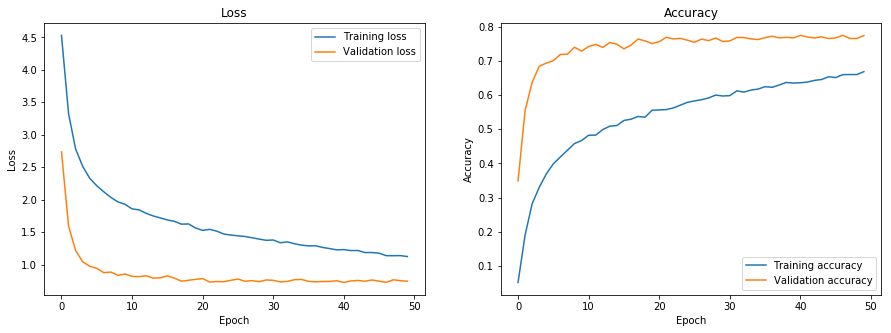

In [0]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(loss, label = "Training loss")
ax[0].plot(val_loss, label = "Validation loss")
ax[0].set_title("Loss")
ax[0].legend()
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[1].plot(acc, label = "Training accuracy")
ax[1].plot(val_acc, label = "Validation accuracy")
ax[1].set_title("Accuracy")
ax[1].legend()
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')

## Test Model

First top-1 then top-5 accuracy

In [0]:
from keras.models import load_model
new_model = load_model('my_dog_model.h5')
validation_generator.reset()
pred = new_model.predict_generator(validation_generator, steps = num_test_files / TEST_BATCH_SIZE)
print("Top-1 Accuracy on Test Set:")
print(np.mean(np.equal(np.transpose(test_labels), np.argmax(pred, axis=-1))))

Top-1 Accuracy on Test Set:
0.7737762237762238


In [0]:
top_cats = np.argsort(-pred, axis=-1)[:,0:5]
in_top_5 = []
for i in range(num_test_files):
    in_top_5.append(test_labels[i] in top_cats[i,:])
print("Top-5 Accuracy on Test Set:")
np.mean(in_top_5)

Top-5 Accuracy on Test Set:


0.968997668997669

<BarContainer object of 120 artists>

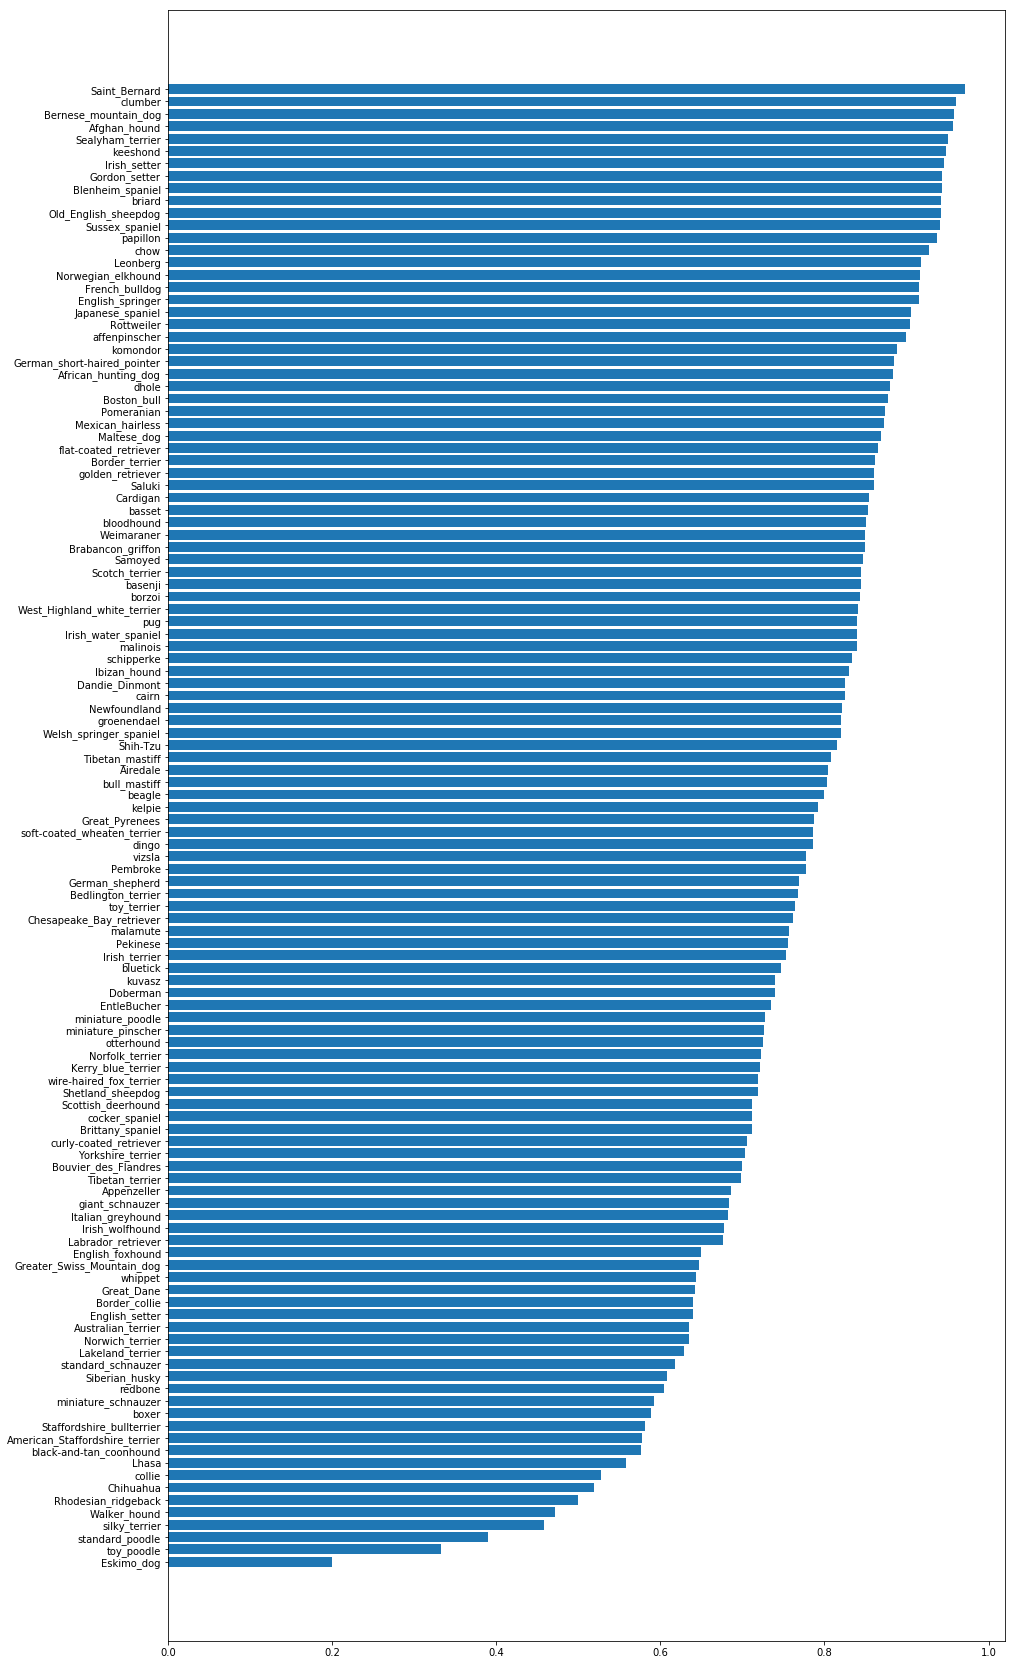

In [0]:
correct_class = np.equal(np.transpose(test_labels), np.argmax(pred, axis=-1))
class_acc = []
for i in range(num_classes):
  a = np.transpose(test_labels) == i
  class_acc.append(np.sum(correct_class * a) / np.sum(a))
a = np.asarray(class_acc)
b = np.argsort(a)
c = np.unravel_index(b, b.shape)
fig = plt.figure(figsize=(15,30))
d = np.asarray(class_list)
plt.barh(d[c],a[c])

<BarContainer object of 120 artists>

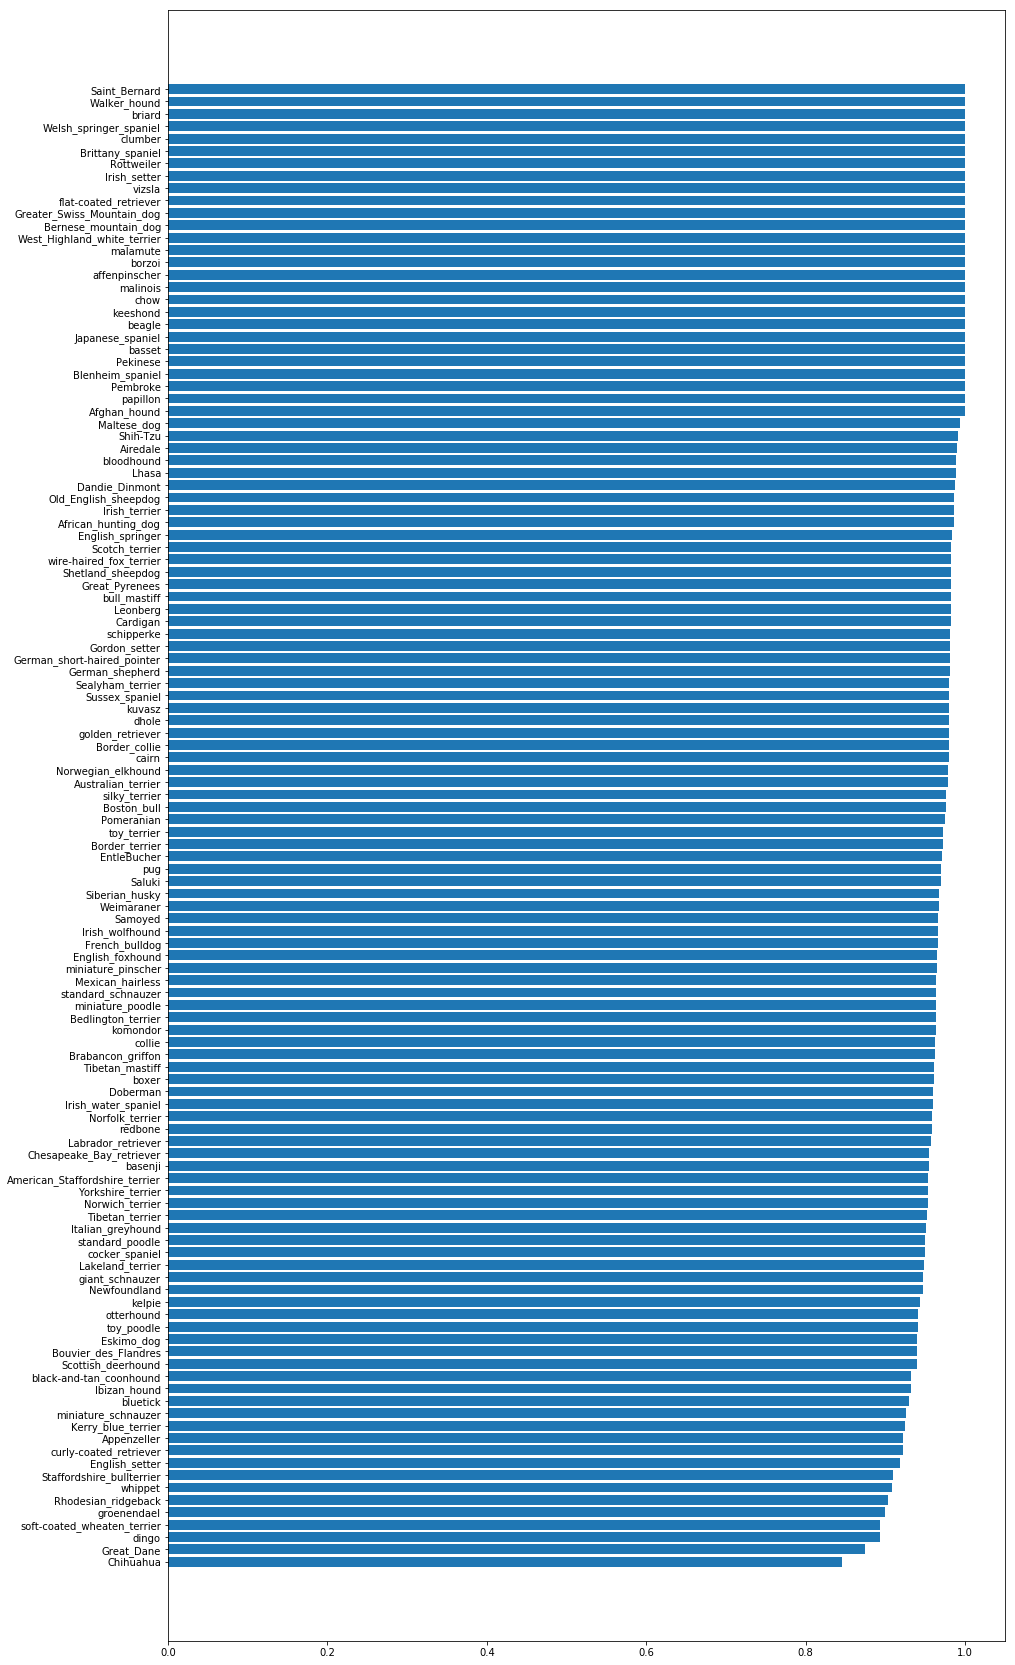

In [0]:
class_acc_top_5 = []
for i in range(num_classes):
  a = np.transpose(test_labels) == i
  class_acc_top_5.append(np.sum(in_top_5 * a) / np.sum(a))
a = np.asarray(class_acc_top_5)
b = np.argsort(a)
c = np.unravel_index(b, b.shape)
fig = plt.figure(figsize=(15,30))
d = np.asarray(class_list)
plt.barh(d[c],a[c])

## Exploration of Failures

From the bar graphs of accuracy per class, it looks like the model is making mistakes when there are multiple categories that are very similar, for example Eskimo dog and Siberian Husky, and toy, miniature and standard poodles.

It is also possible that there is something about the images that aren't been identified correctly, so here we look at a set of the images that are not being identified correctly.

The failure examples seem to be a selection of close-up, whole dog, people in the background, as in the full set, so there doesn't appear to be a type of image that is being mis-classified.

In [0]:
# for those still mis-classified for the top-5
# chose random set of images 8x8
# title for each image being actual class
import random
num_failures = num_test_files-sum(in_top_5)
sorted_failures = np.argsort(in_top_5)
indexes = []
for i in range(min(num_failures,64)):
    rand_index = random.randint(0,num_failures)
    while (sorted_failures[rand_index] in indexes):
        rand_index = random.randint(0,num_failures)
    indexes.append(sorted_failures[rand_index])
indexes.sort()

[]

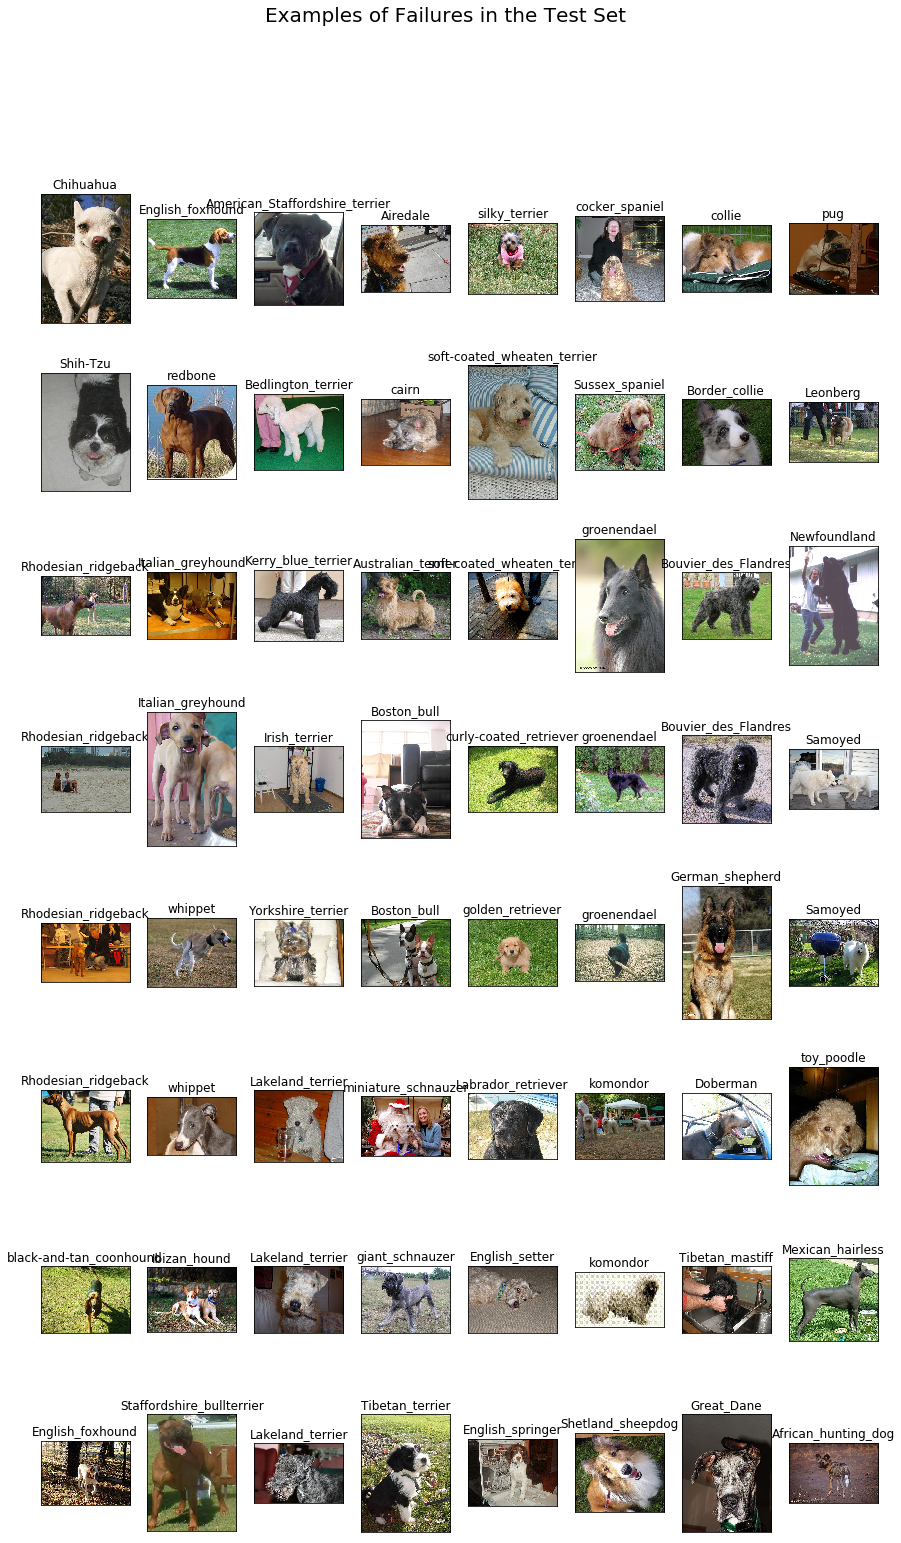

In [0]:
rows = 8
cols = 8

fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Examples of Failures in the Test Set', fontsize=20)

gen_index = 0
img_index = 0
for i in range(cols):
    for j in range(rows):
      if (img_index < num_failures):
        filename = test_files[indexes[img_index]][0][0]
        img = plt.imread("./test_images/" + filename)
        [code_category,index] = filename.split('/',1)
        [code, category] = code_category.split('-',1)
        ax[j][i].imshow(img)
        img_index = img_index + 1
        ax[j][i].set_title(category)
plt.setp(ax, xticks=[], yticks=[])

## Conclusions

Overall, the classifier performs with a decent top-1 accuracy of 77.4% and a top=5 accuracy of 96.9%. Many of the mis-classified images seem to be from categories that are very similar looking dogs, for example toy, miniature, and standard poodles (miniature poodles have a high accuracy, while toy and standard poodles are in the bottom 3 categories).

The next step to improve the model would be to look at these similar categories, possibly by using loss_weights in compile to weight these similar looking categories more than the other categories, or class_weight in fit_generator.

Another way to improve the model would be to use the bounding box annotations to extract just the part of the images containing the dog for training the model.